# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (zademonstrowana na bramce XOR) (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski 1.[5 pkt]
4. Jakość kodu 0.[5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [53]:
from abc import abstractmethod, ABC
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from progressbar import progressbar
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split



In [54]:
def loss_function(x, y):
    return np.mean((x - y) ** 2)

def loss_derivative(x, y):
    return 2 * (x - y)

def reshaping(X_set):
    new_X_set = np.empty((X_set.shape[0], X_set.shape[1], 1))
    for i in range(len(X_set)):
        temp = X_set[i]
        temp = temp.reshape((X_set.shape[1], 1))
        new_X_set[i] = temp
    return new_X_set

def regression_plot(predicted_values, real_values):
    plt.figure(figsize=(7, 6))
    plt.scatter(real_values, predicted_values, color='blue', label='Predicted vs. Real')

    plt.xlabel('Real Values')
    plt.ylabel('Predicted Values')
    plt.title('Regression Plot: Predicted vs. Real Values')

    # Idealna predykcja
    max_val = max(max(real_values), max(predicted_values))
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Perfect Prediction')

    plt.legend()
    plt.grid(True)
    plt.show()


In [55]:
class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x:np.ndarray)->np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative) ->np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate

class FullyConnected(Layer):
    def __init__(self, input_size:int, output_size:int, act_func:Layer, momentum:float=0.5) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(output_size, input_size)
        self.biases = np.zeros((output_size, 1))
        self.input = None
        self.output = None
        self.act_func = act_func
        self.momentum = momentum
        self.prev_weights_update = np.zeros_like(self.weights)
        self.prev_biases_update = np.zeros_like(self.biases)


    def forward(self, x:np.ndarray)->np.ndarray:
        self.input = x
        self.output = np.dot(self.weights, x) + self.biases
        return self.act_func.forward(self.output)

    def backward(self, output_error_derivative) -> np.ndarray:
        new_output_error_derivative = self.act_func.backward(output_error_derivative)
        input_error_derivative = np.dot(self.weights.T, new_output_error_derivative)
        weights_error_derivative = np.dot(new_output_error_derivative, self.input.T)

        # Calculate momentum updates
        weights_update = self.learning_rate * weights_error_derivative + self.momentum * self.prev_weights_update
        biases_update = self.learning_rate * np.sum(new_output_error_derivative, axis=1, keepdims=True) + self.momentum * self.prev_biases_update

        # Update weights and biases
        self.weights -= weights_update
        self.biases -= biases_update

        # Update previous weight updates for momentum
        self.prev_weights_update = weights_update
        self.prev_biases_update = biases_update

        return input_error_derivative

        # self.weights -= self.learning_rate * weights_error_derivative
        # self.biases -= self.learning_rate * np.sum(new_output_error_derivative, axis=1, keepdims=True)
        # return input_error_derivative



class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()
        self.input = None
        self.output = None

    def forward(self, x:np.ndarray)->np.ndarray:
        self.input = x
        self.output = np.tanh(x)
        return self.output

    def backward(self, output_error_derivative)->np.ndarray:
        return output_error_derivative * (1 - np.tanh(self.input) ** 2)
    
class Sigmoid(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        self.output = 1 / (1 + np.exp(-x))
        return self.output

    def backward(self, output_error_derivative) -> np.ndarray:
        return output_error_derivative * self.output * (1 - self.output)
    
class ReLU(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        self.output = np.maximum(0, x)
        return self.output

    def backward(self, output_error_derivative) -> np.ndarray:
        return output_error_derivative * (self.input > 0).astype(int)


class Loss:
    def __init__(self, loss_function:callable, loss_function_derivative:callable)->None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, x:np.ndarray, y:np.ndarray)->np.ndarray:
        """Loss function for a particular x"""
        return self.loss_function(x, y)

    def loss_derivative(self, x:np.ndarray, y:np.ndarray)->np.ndarray:
        """Loss function derivative for a particular x and y"""
        return self.loss_function_derivative(x, y)

class Network:
    def __init__(self, layers:List[Layer], learning_rate:float)->None:
        self.layers = layers
        self.learning_rate = learning_rate

    def compile(self, loss:Loss)->None:
        """Define the loss function and loss function derivative"""
        self.loss = loss

    def __call__(self, x:np.ndarray) -> np.ndarray:
        """Forward propagation of x through all layers"""
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def fit(self,
            x_train:np.ndarray,
            y_train:np.ndarray,
            epochs:int,
            verbose:int=0)->None:
        """Fit the network to the training data"""
        all_current_loss = []
        epoch_loss = np.zeros(1437)
        for layer in self.layers:
            layer.learning_rate = self.learning_rate
        for epoch in range(epochs):
            for i in range(len(x_train)):
                # Forward propagation
                
                output = self(x_train[i])
                
                correct_result = np.zeros((10, 1))
                temp = y_train[i]
                correct_result[y_train[i]] = 1

                # if type(self.layers[-1].act_func) == ReLU:
                #     correct_result = y_train[i]
                
                current_loss = self.loss.loss(output, correct_result)
                loss_derivative = self.loss.loss_derivative(output, correct_result)
                epoch_loss[i] = current_loss
                
                # Backpropagation
                for layer in reversed(self.layers):
                    loss_derivative = layer.backward(loss_derivative)

            all_current_loss.append(np.mean(epoch_loss))
            if verbose:
                print(np.mean(epoch_loss))
        fig2 = plt.plot(all_current_loss)
        plt.show()

In [56]:
def sigmoid_tester(learning_rate, epochs, random_state, amount_of_layers, verbose):
    # sigmoid lr=0.05 e=200
    digits = load_digits()
    X = digits.data
    y = digits.target

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)

    new_X_train = reshaping(X_train)
    new_X_test = reshaping(X_test)

    if amount_of_layers == 3:
        layers = [
            FullyConnected(input_size=X_train.shape[1], output_size=128, act_func=Sigmoid()),  # Warstwa wejściowa
            FullyConnected(input_size=128, output_size=64, act_func=Sigmoid()),  # Ukryta warstwa
            FullyConnected(input_size=64, output_size=10, act_func=Sigmoid()),  # Warstwa wyjściowa
        ]
    elif amount_of_layers == 2:
        layers = [
            FullyConnected(input_size=X_train.shape[1], output_size=128, act_func=Sigmoid()),  # Warstwa wejściowa
            FullyConnected(input_size=128, output_size=10, act_func=Sigmoid()),  # Warstwa wyjściowa
        ]
    else:
        print('Wrong amount of layers')
        raise ValueError
    
    network = Network(layers=layers, learning_rate=learning_rate)

    loss = Loss(loss_function, loss_derivative)
    network.compile(loss=loss)

    network.fit(new_X_train, y_train, epochs, learning_rate, verbose=verbose)

    predictions = []
    for i in range(len(X_test)):
        output = network(new_X_test[i])
        prediction = np.argmax(output)
        predictions.append(prediction)

    accuracy = np.mean(np.array(predictions) == y_test)
    print(f"Accuracy on test set: {accuracy}")

    regression_plot(predictions, y_test)

def tanh_tester(learning_rate, epochs, random_state, amount_of_layers, verbose):
    digits = load_digits()
    X = digits.data
    y = digits.target

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)

    new_X_train = reshaping(X_train)
    new_X_test = reshaping(X_test)

    if amount_of_layers == 3:
        layers = [
            FullyConnected(input_size=X_train.shape[1], output_size=128, act_func=Tanh()),  # Warstwa wejściowa
            FullyConnected(input_size=128, output_size=64, act_func=Tanh()),  # Ukryta warstwa
            FullyConnected(input_size=64, output_size=10, act_func=Tanh()),  # Warstwa wyjściowa
        ]
    elif amount_of_layers == 2:
        layers = [
            FullyConnected(input_size=X_train.shape[1], output_size=128, act_func=Tanh()),  # Warstwa wejściowa
            FullyConnected(input_size=128, output_size=10, act_func=Tanh()),  # Warstwa wyjściowa
        ]
    else:
        print('Wrong amount of layers')
        raise ValueError
    
    network = Network(layers=layers, learning_rate=learning_rate)

    loss = Loss(loss_function, loss_derivative)
    network.compile(loss=loss)

    network.fit(new_X_train, y_train, epochs, learning_rate, verbose=verbose)

    predictions = []
    for i in range(len(X_test)):
        output = network(new_X_test[i])
        prediction = np.argmax(output)
        predictions.append(prediction)

    accuracy = np.mean(np.array(predictions) == y_test)
    print(f"Accuracy on test set: {accuracy}")

    regression_plot(predictions, y_test)

def ReLU_tester(learning_rate, epochs, random_state, amount_of_layers, verbose):
    digits = load_digits()
    X = digits.data
    y = digits.target

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)

    new_X_train = reshaping(X_train)
    new_X_test = reshaping(X_test)

    if amount_of_layers == 3:
        layers = [
            FullyConnected(input_size=X_train.shape[1], output_size=128, act_func=ReLU()),  # Warstwa wejściowa
            FullyConnected(input_size=128, output_size=64, act_func=ReLU()),  # Ukryta warstwa
            FullyConnected(input_size=64, output_size=10, act_func=ReLU()),  # Warstwa wyjściowa
        ]
    elif amount_of_layers == 2:
        layers = [
            FullyConnected(input_size=X_train.shape[1], output_size=128, act_func=ReLU()),  # Warstwa wejściowa
            FullyConnected(input_size=128, output_size=10, act_func=ReLU()),  # Warstwa wyjściowa
        ]
    else:
        print('Wrong amount of layers')
        raise ValueError
    
    network = Network(layers=layers, learning_rate=learning_rate)

    loss = Loss(loss_function, loss_derivative)
    network.compile(loss=loss)

    network.fit(new_X_train, y_train, epochs, learning_rate, verbose=verbose)

    predictions = []
    for i in range(len(X_test)):
        output = network(new_X_test[i])
        prediction = np.argmax(output)
        predictions.append(prediction)

    accuracy = np.mean(np.array(predictions) == y_test)
    print(f"Accuracy on test set: {accuracy}")

    regression_plot(predictions, y_test)

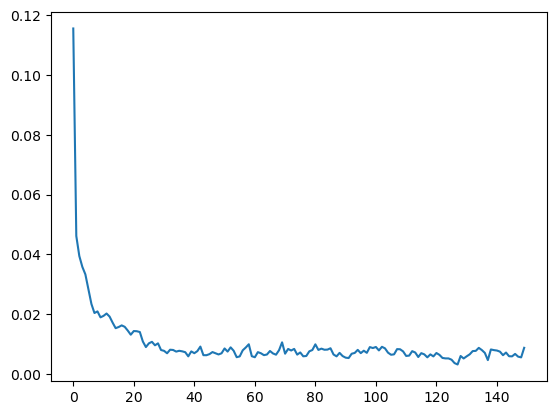

Accuracy on test set: 0.9388038942976356


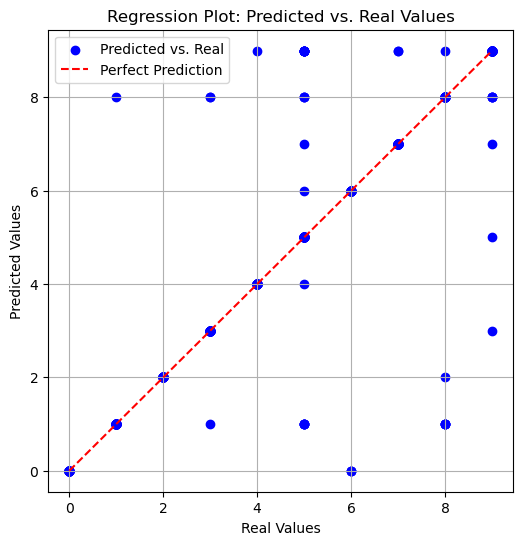

In [62]:
sigmoid_tester(0.05, 150, 42, 3, verbose=1)

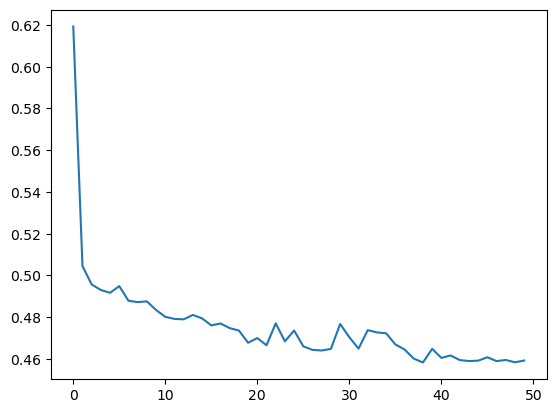

Accuracy on test set: 0.09596662030598054


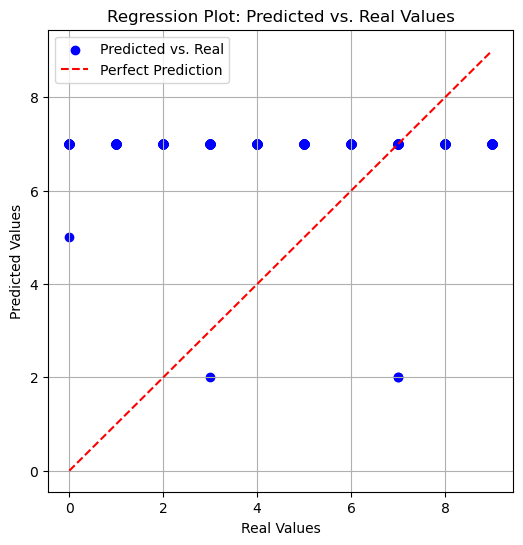

In [60]:
tanh_tester(0.01, 50, 42, 3, verbose=1)

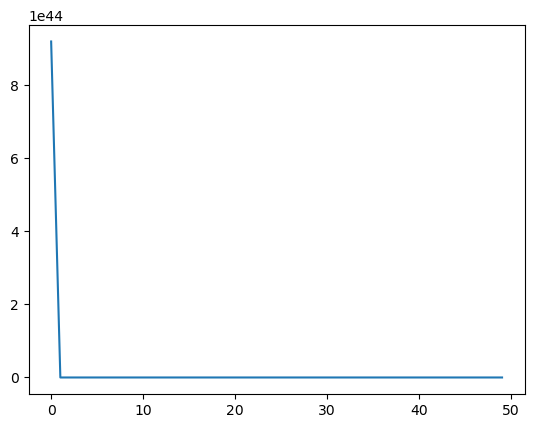

Accuracy on test set: 0.09318497913769123


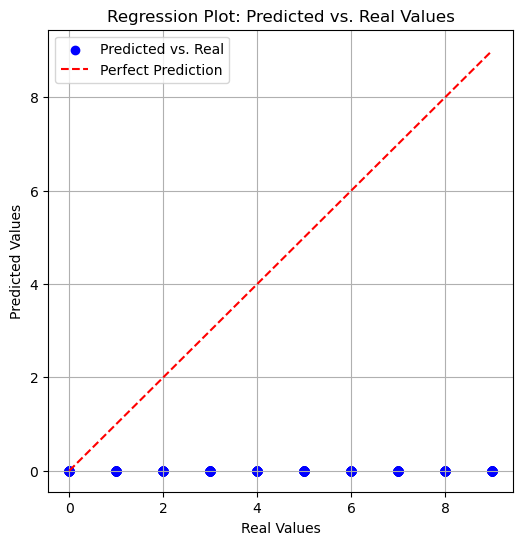

In [61]:
ReLU_tester(0.01, 50, 42, 3, verbose=1)

# Eksperymenty

# Wnioski